# PINN with different weights initialization method
from: Learning in Sinusoidal Spaces with PhysicsInformed Neural Networks, Wong [https://doi.org/10.1109/TAI.2022.3192362]

In [1]:
import torch.nn as nn
import torch.optim as optim
from torch import vmap
from torch.func import jacrev
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
def ODE_1(t, y): # Exponential decay
    # y: R^1, lambda: 0.1
    y = torch.tensor(y, dtype=torch.float32).to(device)
    return -0.1 * y

ODE_1_y0 = torch.tensor([2.0]).to(device)

def ODE_2(t, y): # Van der Pol Oscillator
    # y: R^2, mu: 2
    if not isinstance(y, torch.Tensor):
        y = torch.tensor(y, dtype=torch.float32).to(device)
    
    x = y[0]
    dy = y[1]
    # Parameters
    omega = 1.0
    zeta = 0.5
    
    dydt = torch.stack([dy, -omega**2 * x - 2 * zeta * omega * dy]).to(device)
    return dydt

ODE_2_y0 = torch.tensor([2.0, 0.0]).to(device)

In [3]:
class sinAct(nn.Module):
    def forward(self, x):
        return torch.sin( 2 * torch.acos(torch.tensor(-1.0)).to(device) * x)

In [4]:
# Define the initialization function
def init_weights(m, init_type="xavier"):
    if isinstance(m, nn.Linear):
        if init_type == "xavier":
            nn.init.xavier_uniform_(m.weight)
        elif init_type == "he":
            nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        elif init_type == "xavier_normal":
            nn.init.xavier_normal_(m.weight)
        elif init_type == "he_normal":
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        else:
            raise ValueError(f"Unknown initialization type: {init_type}")
        
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [5]:
class LinearNN(nn.Module):
    def __init__(
        self,
        num_inputs,
        num_layers,
        num_neurons,
        num_outputs,
        act: nn.Module = nn.Tanh(),
        input_act: nn.Module = sinAct()
    ) -> None:
        """Basic neural network architecture with linear layers
        
        Args:
            num_inputs (int, optional): the dimensionality of the input tensor
            num_layers (int, optional): the number of hidden layers
            num_neurons (int, optional): the number of neurons for each hidden layer
            act (nn.Module, optional): the non-linear activation function to use for stitching
                linear layers togeter
        """
        super().__init__()
        
        self.num_inputs = num_inputs
        self.num_neurons = num_neurons
        self.num_layers = num_layers
        
        self.act = act
        self.input_act = input_act

        self.layers = nn.ModuleList()

        # input layer
        self.layers.append(nn.Linear(self.num_inputs, num_neurons))

        # hidden layers with linear layer and activation
        for _ in range(num_layers):
            self.layers.append(nn.Linear(num_neurons, num_neurons))

        # output layer
        self.layers.append(nn.Linear(num_neurons, num_outputs))
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        x = x.reshape(-1, 1)
        
        layer = self.layers[0]
        x = self.input_act(layer(x))
        
        for layer in self.layers[1:-1]:
            x = self.act(layer(x))
            
        x = self.layers[-1](x)
        
        return x

In [6]:
model = LinearNN(1, 4, 64, 2).to(device)

# Apply the initialization function to the network with the desired initialization type
initialization_type = "xavier"  # Change this to "xavier", "xavier_normal", "he", "he_normal", etc.
model.apply(lambda m: init_weights(m, init_type=initialization_type))

# Define the Jacobian function for a single input
def jacobian_fn(x):
    return jacrev(model)(x)

# Use vmap to compute Jacobians for each element in the batch
batched_jacobian_fn = vmap(jacobian_fn)

In [7]:
ODE_batch = vmap(ODE_2, in_dims=0)

In [8]:
def loss_fn(t: torch.Tensor):
    # INTERIOR LOSS
    # NN grads
    y = model(t)
    
    jacobians = batched_jacobian_fn(t)
    dydt = jacobians.squeeze(-1)
    # ODE actual grads
    ode_grads = ODE_batch(t, y)
    interiror = dydt - ode_grads
    
    # BOUNDARY LOSS
    y_0 = model(torch.tensor([0.0]).to(device))
    
    boundary = y_0 - ODE_2_y0
    
    lambda_i = 1.0
    lambda_b = 0.5
    
    loss = nn.MSELoss()
    return lambda_i * loss(interiror, torch.zeros_like(interiror)) + lambda_b * loss(boundary, torch.zeros_like(boundary))
    

In [9]:
batch_size = 128  # number of colocation points to sample in the domain
num_iter = 2000  # maximum number of iterations
learning_rate = 1e-3  # learning rate
weight_decay = 1e-4  # weight decay
T = 10  # final time

optimzier = optim.Adam(model.parameters(), lr=learning_rate)


for i in range(num_iter):
    t = (torch.rand(batch_size) * T).to(device) 
    t.to(device)
    t.requires_grad_(True)
    
    loss = loss_fn(t)
    loss.backward()
    optimzier.step()
    optimzier.zero_grad()
    if i % 10 == 0:
        print(f"Iteration {i}, Loss: {loss.item()}")

/home/vedo/miniconda3/envs/thesis/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1718580740865/work/aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Iteration 0, Loss: 1.7338600158691406
Iteration 10, Loss: 0.3858451545238495
Iteration 20, Loss: 0.28689152002334595
Iteration 30, Loss: 0.12400999665260315
Iteration 40, Loss: 0.15013565123081207
Iteration 50, Loss: 0.13717646896839142
Iteration 60, Loss: 0.10928106307983398
Iteration 70, Loss: 0.10687336325645447
Iteration 80, Loss: 0.12567143142223358
Iteration 90, Loss: 0.16545306146144867
Iteration 100, Loss: 0.11967986077070236
Iteration 110, Loss: 0.15522167086601257
Iteration 120, Loss: 0.1535567194223404
Iteration 130, Loss: 0.1801633983850479
Iteration 140, Loss: 0.08575475215911865
Iteration 150, Loss: 0.12100136280059814
Iteration 160, Loss: 0.1348692625761032
Iteration 170, Loss: 0.13757818937301636
Iteration 180, Loss: 0.08797655999660492
Iteration 190, Loss: 0.16941295564174652
Iteration 200, Loss: 0.13114602863788605
Iteration 210, Loss: 0.09703012555837631
Iteration 220, Loss: 0.11615922302007675
Iteration 230, Loss: 0.07945828139781952
Iteration 240, Loss: 0.098051905

In [10]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
# Solve the ODE system numerically
from scipy.integrate import solve_ivp

In [12]:
def ODE_1_np(t, y):
    dydt = ODE_1(t, y)
    return dydt.cpu().numpy()


def ODE_2_np(t,y):
    dydt = ODE_2(t, y)
    return dydt.cpu().numpy()

In [13]:
sol = solve_ivp(ODE_2_np, (0, T), ODE_2_y0.cpu().numpy(), method='RK45', t_eval=np.linspace(0, T, 100))

In [14]:
t = torch.linspace(0, T, 100).view(-1, 1).to(device)

t_np = t.cpu().detach().numpy()
y_pred_np = model(t).cpu().detach().numpy()


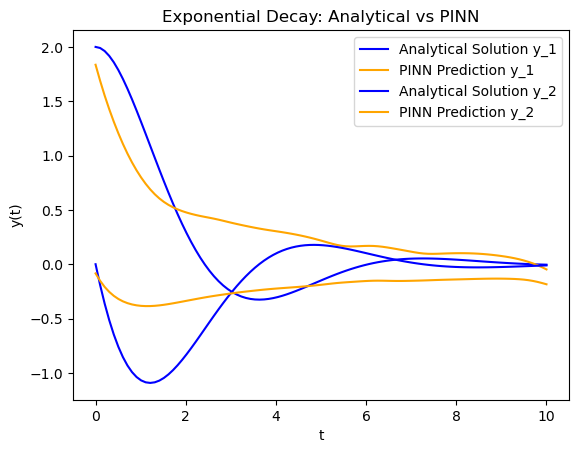

In [15]:
num_y = y_pred_np.shape[1]
for i in range(num_y):
    plt.plot(sol.t, sol.y.T[:, i], color='blue', label=f'Analytical Solution y_{i+1}')
    plt.plot(t_np, y_pred_np[:, i], color='orange', label=f'PINN Prediction y_{i+1}')

plt.xlabel('t')
plt.ylabel('y(t)')
plt.legend()
plt.title('Exponential Decay: Analytical vs PINN')
plt.show()